<a href="https://colab.research.google.com/github/SuzyAdel/Arabic_classification_transformer/blob/main/TEXT_CLASSIFICATION_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arabic text classifier/ semantic analysis
## suzy Adel Wahba 211004476

In [21]:
!pip install gensim tensorflow numpy pandas scikit-learn matplotlib seaborn

In [22]:
import gensim
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dropout, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam

## Load Arabic Dataset
use arabic dataset of reviews to train and make sure there are equal amount of coments / reviews from each

In [23]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/a1/arabic_reviews.csv')

# Show some rows to ensure dataset is correctly loaded
print("Sample Data:")
print(df.head())

# Check class balance
print("Class Distribution:")
print(df['label'].value_counts())

Sample Data:
      label                                               text
0  Positive  ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1  Positive  أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2  Positive  هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3  Positive  خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4  Positive  ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
Class Distribution:
label
Positive    33333
Mixed       33333
Negative    33333
Name: count, dtype: int64


      label                                               text
0  Positive  ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1  Positive  أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2  Positive  هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3  Positive  خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4  Positive  ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


<ipython-input-24-3c014d0a1fdc>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'], palette="Set2")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


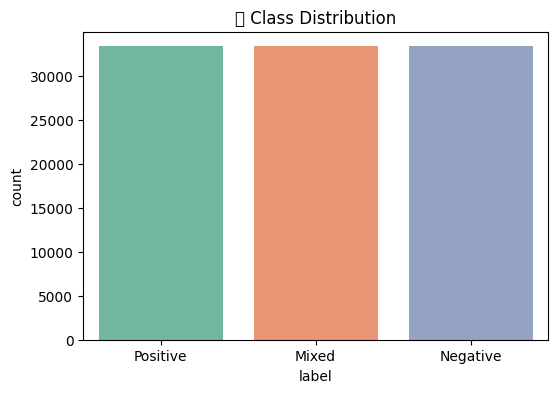

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check first few rows
print(df.head())

# Check label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['label'], palette="Set2")
plt.title("🔹 Class Distribution")
plt.show()


## clean // normalize the text

In [25]:
!pip install arabic-reshaper

In [26]:
!pip install tashaphyne

In [27]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [28]:
import re
import arabic_reshaper
from tashaphyne.stemming import ArabicLightStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Arabic stopwords list
stop_words = set(stopwords.words("arabic"))

def clean_text(text):
    # Normalize Arabic letters
    text = re.sub(r"[إأآا]", "ا", text)
    text = re.sub(r"ى", "ي", text)
    text = re.sub(r"ؤ", "و", text)
    text = re.sub(r"ئ", "ي", text)
    text = re.sub(r"ة", "ه", text)

    # Remove punctuation and numbers
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)

    # Tokenize and remove stopwords
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]

    return " ".join(words)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Show cleaned samples
print(df[['text', 'clean_text']].head())

                                                text  \
0  ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...   
1  أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...   
2  هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...   
3  خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...   
4  ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...   

                                          clean_text  
0  ممتاز نوعا النظافه والموقع والتجهيز والشاطيء ا...  
1  احد اسباب نجاح الامارات ان شخص الدوله يعشق ترا...  
2  هادفه وقويه تنقلك صخب شوارع القاهره الي هدوء ج...  
3  خلصنا مبدييا اللي مستني ابهار زي الفيل الازرق ...  
4  ياسات جلوريا جزء يتجزا دبي فندق متكامل الخدمات...  


## Load AraVec Embeddings
instead of making my own word to vec from scratch, implement a more accurate and more trained model

In [29]:
from gensim.models import KeyedVectors

In [30]:
import os
import shutil  # For deleting folders if needed
from zipfile import ZipFile  # Importing ZipFile to handle zip files

In [31]:
# Define paths
zip_path = "/content/drive/MyDrive/a1/Twt-CBOW.zip"
extract_folder = "/content/aravec_model"
model_path = os.path.join(extract_folder, "Twt-CBOW")

# Check if already unzipped, if not then unzip
if not os.path.exists(model_path):
    print("Unzipping AraVec embeddings...")
    # Remove any previously unzipped folder to prevent conflicts
    if os.path.exists(extract_folder):
        !rm -rf {extract_folder}

    # Unzipping
    os.makedirs(extract_folder, exist_ok=True)
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print("Successfully unzipped!")
else:
    print("AraVec embeddings already extracted.")

AraVec embeddings already extracted.


In [32]:
# Check the extracted folder contents
extracted_files = os.listdir("/content/aravec_model")
print(extracted_files)

['Twt-CBOW.syn1neg.npy', 'Twt-CBOW', 'Twt-CBOW.wv.syn0.npy']


In [33]:
import os
print(os.path.exists("/content/aravec_model/Twt-CBOW"))  # Should print True

True


In [34]:
print(os.listdir("/content/aravec_model"))

['Twt-CBOW.syn1neg.npy', 'Twt-CBOW', 'Twt-CBOW.wv.syn0.npy']


In [35]:
#!mv /content/aravec_model/Twt-CBOW /content/aravec_model/Twt-CBOW.bin

In [36]:
from gensim.models import KeyedVectors
import os

# Assuming you extracted the AraVec model to '/content/aravec_model'
model_file = "/content/aravec_model/Twt-CBOW"
# model_file = "Twt-CBOW"

#aravec_path = os.path.join(model_folder, model_file)

# Load the AraVec model
#aravec = KeyedVectors.load_word2vec_format(model_file, binary=False, encoding='utf8', unicode_errors='replace')
aravec = gensim.models.Word2Vec.load(model_file)
# Tokenize words and prepare embedding matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Tokenize dataset
tokenizer = Tokenizer(oov_token="<OOV>") # Add out-of-vocabulary token
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # +1 for padding

# Create embedding matrix
embedding_dim = 300  # AraVec uses 300-dimensional embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in aravec.wv:
        embedding_matrix[i] = aravec.wv[word]

print(f"✅ Loaded AraVec embeddings for {len(embedding_matrix)} words.")


✅ Loaded AraVec embeddings for 282203 words.


##Prepare Data for Training

prepare arabic text to the sequence and add the padding/ matrix

In [37]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Encode labels (Negative = 0, Mixed = 1, Positive = 2)
label_mapping = {'Negative': 0, 'Mixed': 1, 'Positive': 2}
df['label_id'] = df['label'].map(label_mapping)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label_id'], test_size=0.1, random_state=42, stratify=df['label_id']
)

# Convert text to sequences
max_length = 100  # Adjust as needed
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')

# Convert labels to categorical (for softmax)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

print("✅ Data successfully prepared for training.")

✅ Data successfully prepared for training.


##  Build & Train the Improved RNN Model



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Define model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    Bidirectional(LSTM(64, return_sequences=True, activation='tanh')),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dense(3, activation='softmax')  # 3 output classes
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train_seq, y_train, epochs=6, batch_size=64, validation_data=(X_test_seq, y_test))


Epoch 1/6
 159/1407 ━━━━━━━━━━━━━━━━━━━━ 11:06 534ms/step - accuracy: 0.5101 - loss: 0.9587

## Evaluate the Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict on test set
y_pred = np.argmax(model.predict(X_test_seq), axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Negative', 'Mixed', 'Positive']))

# Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Mixed', 'Positive'], yticklabels=['Negative', 'Mixed', 'Positive'])
plt.title("Confusion Matrix")
plt.show()

In [ ]:
new_sentences = ["الخدمة كانت رائعة جدا", "التجربة كانت سيئة للغاية", "كان الموضوع عادياً تماماً"]
new_sequences = pad_sequences(tokenizer.texts_to_sequences(new_sentences), maxlen=max_length, padding='post')

predictions = np.argmax(model.predict(new_sequences), axis=1)
label_map = {0: "سلبي", 1: "مختلط", 2: "إيجابي"}
print("Predictions:", [label_map[p] for p in predictions])

# I realized that all these extra layers and tweaks just slowed things down. The simple LSTM setup works best for me — clean, efficient, and fast enough without overkill.

# overal trials
1. Original model:
2 Bidirectional LSTM layers (128 & 64), dropout, simple and balanced.
2. First modification:
Switched to GRU, added GlobalMaxPooling1D, Dense(64), and recurrent dropout.
3. Second modification:
Enabled mixed precision, used learning rate scheduler — became too heavy and slow.


github linke of my repo : https://github.com/SuzyAdel/Arabic_classification_transformer